In [125]:
#%pylab inline
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import string
import matplotlib.cm as cm
import os
from scipy import ndimage
import os
import pandas as pd

In [126]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)
mr=((2*illd+2*illt+ig)+ii*(ng**2))/(refc**2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

masa_eq = 200 # ESto toca calcularlo correctamente

gamma = 1 # aceleracion

def accel(vx, ddt):
    return ndimage.gaussian_filter1d(vx, sigma=20, order=1, mode='wrap') / ddt

def frodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    return wr*fr*np.cos(theta) # (N)

def frodadura_const(vx):
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    return w*fr*np.cos(theta) # (N)

# Fuerza del ángulo de la carretera
def finclinacion(theta):
    return w*np.sin(theta) # (N)

# Fuerza de arrastre
def farrastre(vx):
    return (1.0/2.0)*rho*af*cd*(vx+vw)**2 # (N)

# Fuerza de tracción, Torque del Motor
def ftraccion(ax,Fg,Fw,Fr):
    # Ft=((ti*ng*etaf)/refc)-(((ii-ig)*ng^2)+ieje+illd*2+illt*2)*(ax/(refc^2)) # (N)
    return masa*ax+Fg+Fw+Fr

#Torque para motor de combustion
def torquemotor(ax,Ft):
    return (Ft+(((ii-ig)/(ng**2))+ieje+illd*2+illt*2)*(ax/(refc**2)))*(refc/(ng*etaf))

#Torque para kart electrico
def torquemotor_curva(vx):
    omega=((vx*ng)/refc)*(60/(2*np.pi))
    if(omega>5000):
        omega=5000
    P=((-0.00000004564538677*omega**3)+(0.0001056995459*omega**2)+(1.53209191*omega)-1.895523696)
    T=P/(omega*2*np.pi/60)
    #if (T>5.42):
     #   T= 5.42
    return T
#Caracterizacion para aceleracion
def dveldt(velv,t0,ng_0,masa_0):
    xx,vel = velv
    omega_llanta = vel/refc
    omega_motor = omega_llanta/ng
    frod = frodadura_const(vel*3.6)
    farr = farrastre(vel)
    fincli = finclinacion(theta)
    return [vel,(torquemotor_curva(vel)*ng_0*etaf/refc-frod-farr-fincli)/(masa_0+mr)]
    
#Caracterizacion para freno
def dveldt_freno(velv,t0,ng_0,masa_0):
    xx,vel = velv
    omega_llanta = vel/refc
    omega_motor = omega_llanta/ng
    frod = frodadura_const(vel*3.6)
    farr = farrastre(vel)
    fincli = finclinacion(theta)
    torque_frenado=-18
    return [vel,(torque_frenado*ng_0*etaf/refc-frod-farr-fincli)/(masa_0+mr)]

def vangularmotor(vx):
    return (vx*ng)/refc

# Función para abrir los archivos de VBOX

Con esta función es posible abrir los archivos de datos de ambos VBOX, para utilizarla solamente es necesario crear una variable con el nombre del archivo (Sin el .VBO).

In [127]:
electrico='VBS__047'
combustion='VBOX0019'
def carga(archivo):
    base_dir = os.path.join( '.','data_electrico')
    data_file = archivo+'.VBO'
    with open(os.path.join(base_dir,data_file), 'r',encoding="cp1252") as vboxdata:
        section = []
        time_a = []
        lat_a = []
        leng_a = []
        vel = []
        height = []
        vertv = []
        for line in vboxdata:
            if line[0] == '[':
                section = str.replace(line, "\n","")
                continue
            if section == '[column names]':
                col_names = str.replace(line, "  \n","").split('  ')
                section = []
            if section == '[data]':
                linesplit = str.replace(line, " \n","").split(' ')
                time_a.append(float(linesplit[1][0:2])*3600+float(linesplit[1][2:4])*60+float(linesplit[1][4:]))
                lat_a.append(float(linesplit[2]))
                leng_a.append(float(linesplit[3]))
                vel.append(float(linesplit[4]))
                height.append(float(linesplit[6]))
                #vertv.append(float(linesplit[7]))

    time_a = np.asarray(time_a)
    time_base = time_a[0]
    time = time_a - time_base
    lat_a = np.asarray(lat_a)
    lat = lat_a/60.0
    leng_a = np.asarray(leng_a)
    leng = -leng_a/60.0
    vel = np.asarray(vel)
    height = np.asarray(height)
    #vertv = np.asarray(vertv)
    data_dict = {"TIME":time, "LAT":lat, "LONG":leng, "VEL":vel,"HEIGHT":height}
    data=pd.DataFrame.from_dict(data_dict, orient='columns', dtype=None)
    return data

In [128]:
#Se define el kart electrico
vbs_1=carga(electrico)
#Se define el kart de combustión interna
vbs_2=carga(combustion)

In [129]:
#Delta de Tiempo
dt=vbs_1['TIME'][1]-vbs_1['TIME'][0]
dt2=vbs_2['TIME'][1]-vbs_2['TIME'][0]

# Kart Eléctrico

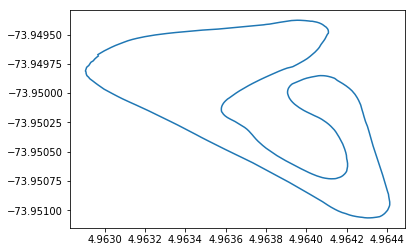

In [130]:
pylab.plot(vbs_1['LAT'][339:1542],vbs_1['LONG'][339:1542])

## Tiempo de Vuelta 

In [131]:
tiempo_de_vuelta=vbs_1['TIME'][1542]-vbs_1['TIME'][339]
print('El tiempo de vuelta es:', tiempo_de_vuelta, '[s]')

El tiempo de vuelta es: 60.15 [s]


# Kart Combustión Interna

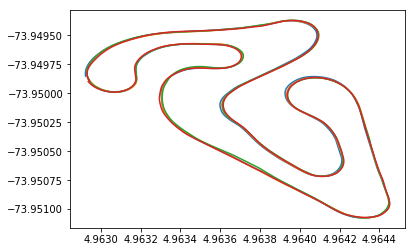

In [132]:
pylab.plot(vbs_2['LAT'][21260:26770],vbs_2['LONG'][21260:26770])
pylab.plot(vbs_2['LAT'][26770:32260],vbs_2['LONG'][26770:32260])
pylab.plot(vbs_2['LAT'][32260:37755],vbs_2['LONG'][32260:37755])
pylab.plot(vbs_2['LAT'][37760:43240],vbs_2['LONG'][37760:43240])

## Tiempo de Vuelta

In [133]:
tiempo_de_vuelta2=vbs_2['TIME'][26780]-vbs_2['TIME'][21260]
tiempo_de_vuelta21=vbs_2['TIME'][32260]-vbs_2['TIME'][26770]
tiempo_de_vuelta22=vbs_2['TIME'][37755]-vbs_2['TIME'][32260]
tiempo_de_vuelta23=vbs_2['TIME'][43240]-vbs_2['TIME'][37760]
print('Los tiempos de vuelta son:', tiempo_de_vuelta2, 's,', tiempo_de_vuelta21,'s,', tiempo_de_vuelta22, 's y',tiempo_de_vuelta23, 's')

Los tiempos de vuelta son: 55.2 s, 54.9 s, 54.95 s y 54.8 s


De este modo la mejor vuelta se dió en la cuarta prueba con un tiempo de 54.8 segundos, para realizar la comparación con el kart eléctrico se utilizará este tiempo.

# Comparación

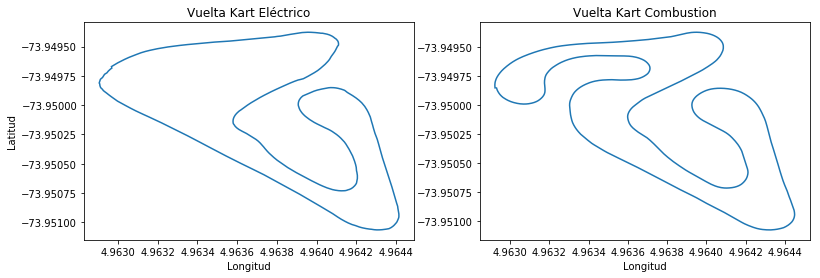

In [134]:
pylab.figure(figsize=(13,4))
pylab.subplot(1,2,2)
pylab.title("Vuelta Kart Combustion")
pylab.xlabel("Longitud")
pylab.ylabel ("Latitud")
pylab.plot(vbs_2['LAT'][21260:26780],vbs_2['LONG'][21260:26780])
pylab.subplot(1,2,1)
pylab.title("Vuelta Kart Eléctrico")
pylab.xlabel("Longitud")
pylab.ylabel ("Latitud")
pylab.plot(vbs_1['LAT'][339:1542],vbs_1['LONG'][339:1542])

Se observa que para ambas mediciones no se utilizó el mismo trazado de la pista, de este modo no se puede comparar los tiempos de vuelta directamente, por esto es necesario recortar la pista hasta el punto en el cual el trazado de la pista es el mismo.

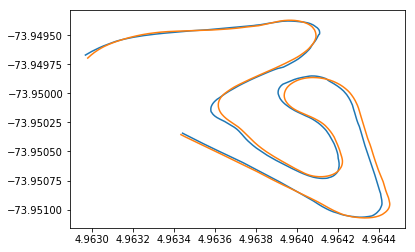

In [135]:
pylab.plot(vbs_1['LAT'][339:1400],vbs_1['LONG'][339:1400])
pylab.plot(vbs_2['LAT'][37900:41790],vbs_2['LONG'][37900:41790])

Ahora que se encontró un trazado similar se procede a calcular el tiempo de vuelta.

## Tiempo de vuelta

In [136]:
electrico = vbs_1['TIME'][1400]-vbs_1['TIME'][339]
combustion = vbs_2['TIME'][41790]-vbs_2['TIME'][37900]
t_vuel = {"Eléctrico":electrico, "Combustión":combustion}
tiempo_vuelta = pd.DataFrame(t_vuel, index=['Tiempo [S]'])
tiempo_vuelta

,Combustión,Eléctrico
Tiempo [S],38.9,53.05


## Velocidad vs Tiempo

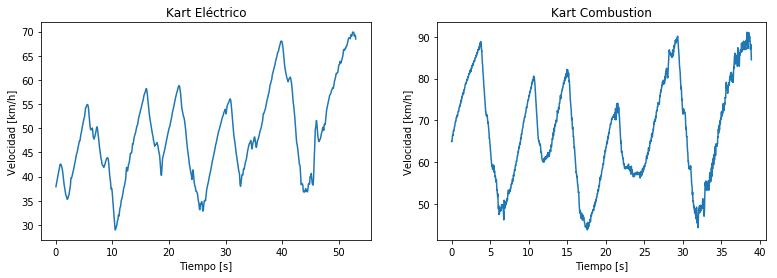

In [137]:
#Se define el tiempo a usar para las demás gráficas
tiempo_ele=vbs_1['TIME'][339:1400]-vbs_1['TIME'][339]
tiempo_com=vbs_2['TIME'][37900:41790]-vbs_2['TIME'][37900]

pylab.figure(figsize=(13,4))
pylab.subplot(1,2,2)
pylab.title("Kart Combustion")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Velocidad [km/h]")
pylab.plot(tiempo_com,vbs_2['VEL'][37900:41790])
pylab.subplot(1,2,1)
pylab.title("Kart Eléctrico")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Velocidad [km/h]")
pylab.plot(tiempo_ele,vbs_1['VEL'][339:1400])

## Aceleración vs Tiempo

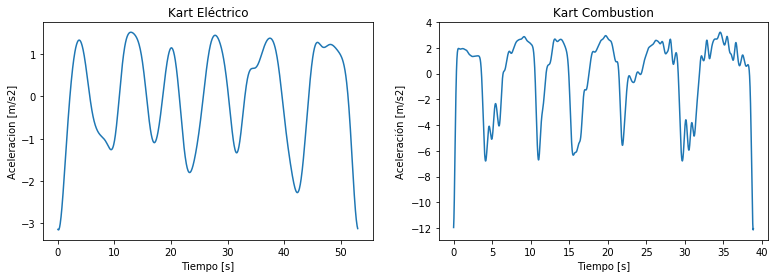

In [138]:
velms_el = vbs_1['VEL']/3.6
velms_com = vbs_2['VEL']/3.6
acx_el = accel(velms_el[339:1400],dt)
acx_com = accel(velms_com[37900:41790],dt2)

pylab.figure(figsize=(13,4))
pylab.subplot(1,2,2)
pylab.title("Kart Combustion")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Aceleración [m/s2]")
pylab.plot(tiempo_com,acx_com)
pylab.subplot(1,2,1)
pylab.title("Kart Eléctrico")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Aceleracion [m/s2]")
pylab.plot(tiempo_ele,acx_el)

## Fuerzas vs Tiempo

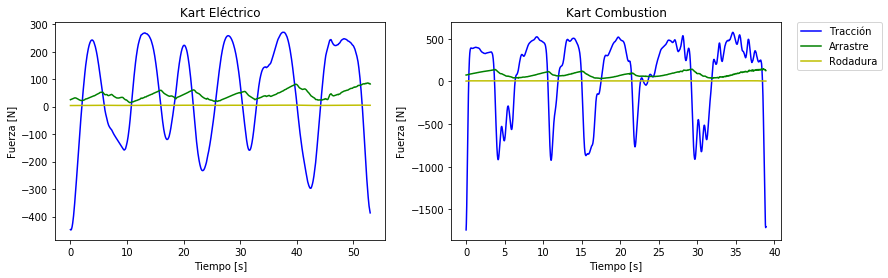

In [139]:
finc_el = finclinacion(theta)
farr_el = farrastre(velms_el[339:1400])
frod_el = frodadura(vbs_1['VEL'][339:1400],acx_el)
ftrac_el = ftraccion(acx_el,finc_el,farr_el,frod_el)
finc_com = finclinacion(theta)
farr_com = farrastre(velms_com[37900:41790])
frod_com = frodadura(vbs_2['VEL'][37900:41790],acx_com)
ftrac_com = ftraccion(acx_com,finc_com,farr_com,frod_com)

pylab.figure(figsize=(13,4))
pylab.subplot(1,2,2)
pylab.title("Kart Combustion")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Fuerza [N]")
pylab.plot(tiempo_com,ftrac_com, '-b', label='Tracción')
pylab.plot(tiempo_com,farr_com,'-g', label='Arrastre')
pylab.plot(tiempo_com,frod_com,'-y', label='Rodadura')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.subplot(1,2,1)
pylab.title("Kart Eléctrico")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Fuerza [N]")
pylab.plot(tiempo_ele,ftrac_el,'-b')
pylab.plot(tiempo_ele,farr_el,'-g')
pylab.plot(tiempo_ele,frod_el,'-y')

## Torque vs Tiempo

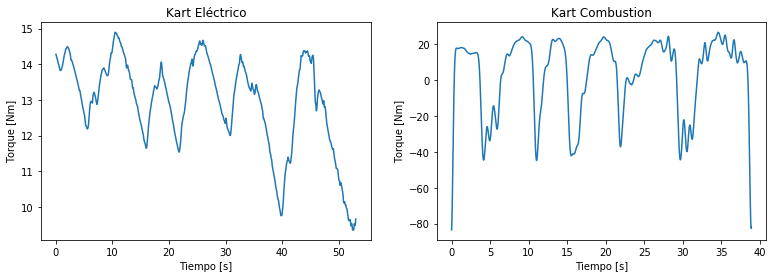

In [140]:
#Funcion para calcular el torque para un rango de velocidades
def torque_ele(func,vel):
    torq=[]
    for vel in vel:
        a=func(vel)
        torq.append(a)
    return torq

torque_el=torque_ele(torquemotor_curva,velms_el[339:1400])
torque_com = torquemotor(acx_com,ftrac_com)

pylab.figure(figsize=(13,4))
pylab.subplot(1,2,2)
pylab.title("Kart Combustion")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Torque [Nm]")
pylab.plot(tiempo_com,torque_com)
pylab.subplot(1,2,1)
pylab.title("Kart Eléctrico")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Torque [Nm]")
pylab.plot(tiempo_ele,torque_el)

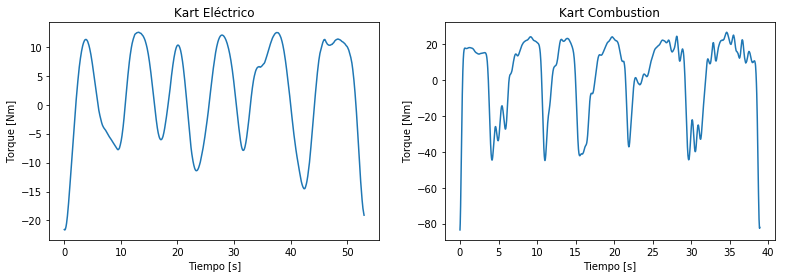

In [141]:
torque_el=torquemotor(acx_el,ftrac_el)
torque_com = torquemotor(acx_com,ftrac_com)

pylab.figure(figsize=(13,4))
pylab.subplot(1,2,2)
pylab.title("Kart Combustion")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Torque [Nm]")
pylab.plot(tiempo_com,torque_com)
pylab.subplot(1,2,1)
pylab.title("Kart Eléctrico")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Torque [Nm]")
pylab.plot(tiempo_ele,torque_el)

## Velocidad angular vs Tiempo

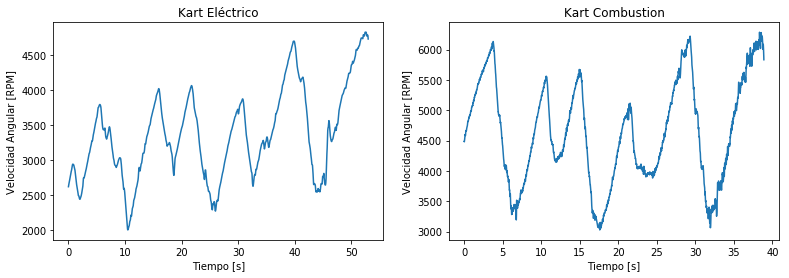

In [142]:
omega_el= vangularmotor(velms_el[339:1400])
omega_com = vangularmotor(velms_com[37900:41790])

pylab.figure(figsize=(13,4))
pylab.subplot(1,2,2)
pylab.title("Kart Combustion")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Velocidad Angular [RPM]")
pylab.plot(tiempo_com,omega_com*30/np.pi)
pylab.subplot(1,2,1)
pylab.title("Kart Eléctrico")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Velocidad Angular [RPM]")
pylab.plot(tiempo_ele, omega_el*30/np.pi)

## Potencia vs Tiempo

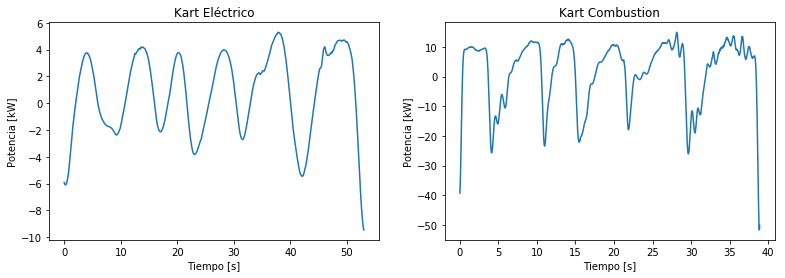

In [143]:
pot_el=omega_el*torque_el
pot_com=omega_com*torque_com

pylab.figure(figsize=(13,4))
pylab.subplot(1,2,2)
pylab.title("Kart Combustion")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Potencia [kW]")
pylab.plot(tiempo_com,pot_com/1000)
pylab.subplot(1,2,1)
pylab.title("Kart Eléctrico")
pylab.xlabel("Tiempo [s]")
pylab.ylabel ("Potencia [kW]")
pylab.plot(tiempo_ele, pot_el/1000)